## Health Insurance Charge Prediction

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import pickle
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

### Data Collection

In [37]:
raw_data = pd.read_csv('insurance_pre.csv', index_col=None)
raw_data

,age,sex,bmi,children,smoker,charges
0,19,female,27.900,0,yes,16884.92400
1,18,male,33.770,1,no,1725.55230
2,28,male,33.000,3,no,4449.46200
3,33,male,22.705,0,no,21984.47061
4,32,male,28.880,0,no,3866.85520
...,...,...,...,...,...,...
1333,50,male,30.970,3,no,10600.54830
1334,18,female,31.920,0,no,2205.98080
1335,18,female,36.850,0,no,1629.83350
1336,21,female,25.800,0,no,2007.94500


In [38]:
data = raw_data

### Data Preprocessing

In [39]:
data.shape

(1338, 6)

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(2)
memory usage: 62.8+ KB


In [41]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [42]:
data = pd.get_dummies(data,dtype=int,drop_first=True)
data

,age,bmi,children,charges,sex_male,smoker_yes
0,19,27.900,0,16884.92400,0,1
1,18,33.770,1,1725.55230,1,0
2,28,33.000,3,4449.46200,1,0
3,33,22.705,0,21984.47061,1,0
4,32,28.880,0,3866.85520,1,0
...,...,...,...,...,...,...
1333,50,30.970,3,10600.54830,1,0
1334,18,31.920,0,2205.98080,0,0
1335,18,36.850,0,1629.83350,0,0
1336,21,25.800,0,2007.94500,0,0


## Data Analysis (Univariate & Bivariate)

### Q1. What is the distribution of Age 

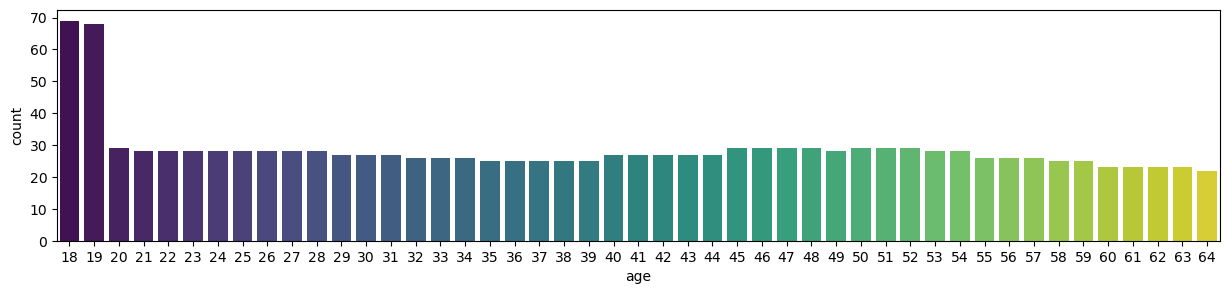

In [154]:
plt.figure(figsize=(15,3))
sb.countplot(data=data, x='age', palette="viridis")  # You can change "viridis" to any other Seaborn palette
plt.show()


### Q2. What is the distribution of BMI 

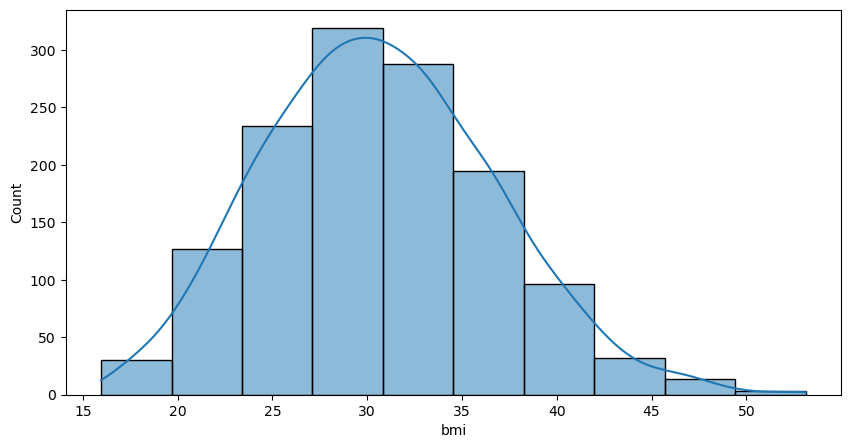

In [76]:
plt.figure(figsize=(10,5))
#custom_colors = ['#FF6347', '#4682B4', '#32CD32', '#FFD700', '#9370DB'] 
sb.histplot(data=data, x='bmi', bins=10, palette='#FF6347', kde=True)
plt.show()

### Q3. What is the dstribution of BMI based on sex ?

Text(0.5, 1.0, 'BMI Distribution by Gender')

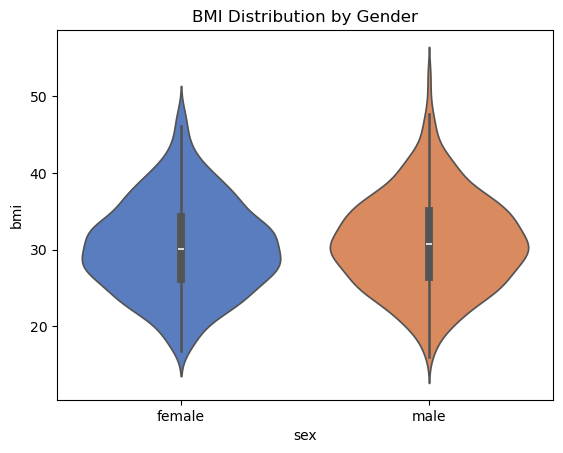

In [147]:
sb.violinplot(data=raw_data, x='sex', y='bmi', palette="muted")
plt.title("BMI Distribution by Gender")

### Q4. What is the average insurance charge based on the age group ?

In [140]:
charge_mean_byage = data.groupby('age')['charges'].mean().reset_index()
charge_mean_byage.head()

,age,charges
0,18,7086.217556
1,19,9747.909335
2,20,10159.697736
3,21,4730.464330
4,22,10012.932802


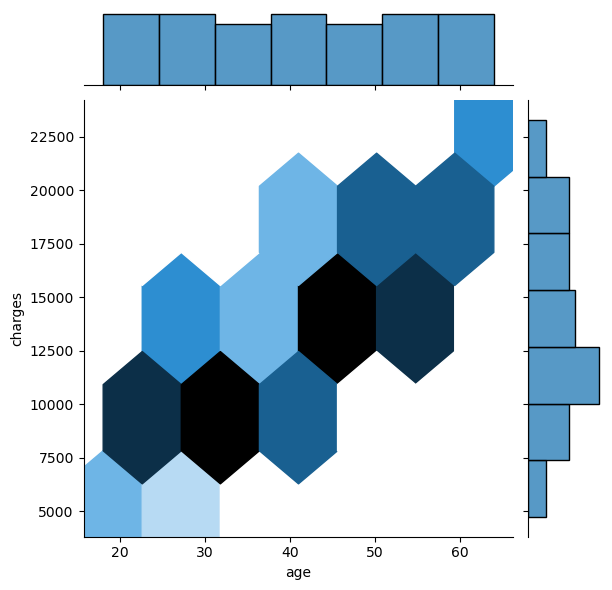

In [151]:
sb.jointplot(data=charge_mean_byage, x = 'age', y='charges', kind='hex')
plt.show()

### Q5. How is the smokers spread based on Gender?

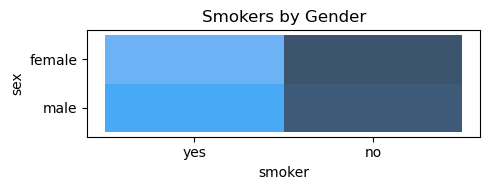

In [152]:
plt.figure(figsize=(5,2))
sb.histplot(data=raw_data, x='smoker', y='sex', palette='viridis')
plt.title('Smokers by Gender')

plt.tight_layout()
plt.show()

### Q6. Age vs. Charges, with linear fit for smoker vs. non-smoker

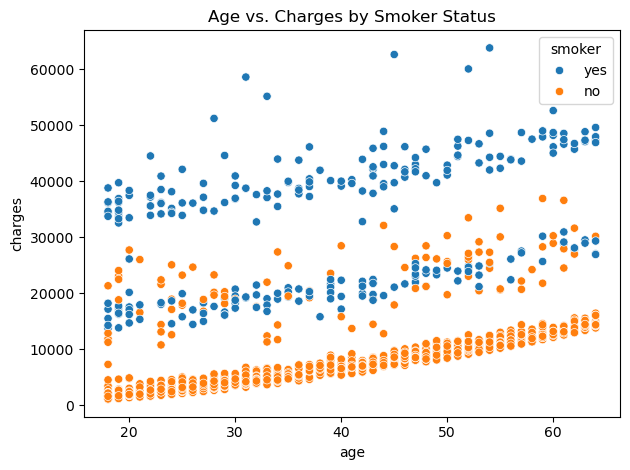

In [153]:
sb.scatterplot(data=raw_data, x='age', y='charges', hue='smoker')
plt.title("Age vs. Charges by Smoker Status")

plt.tight_layout()
plt.show()

### Q7. BMI vs. Charges, with linear fit for smoker vs. non-smoker

Text(0.5, 1.0, 'BMI vs. Charges (Colored by Smoker Status)')

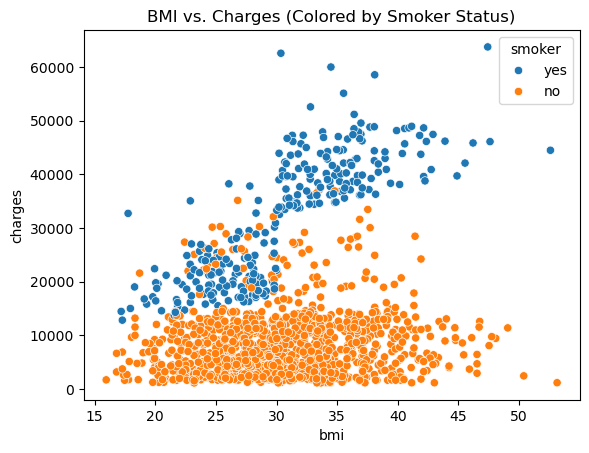

In [129]:
sb.scatterplot(data=raw_data, x='bmi', y='charges', hue='smoker')
plt.title("BMI vs. Charges (Colored by Smoker Status)")

### Q8. Visualize the relationship between all the features

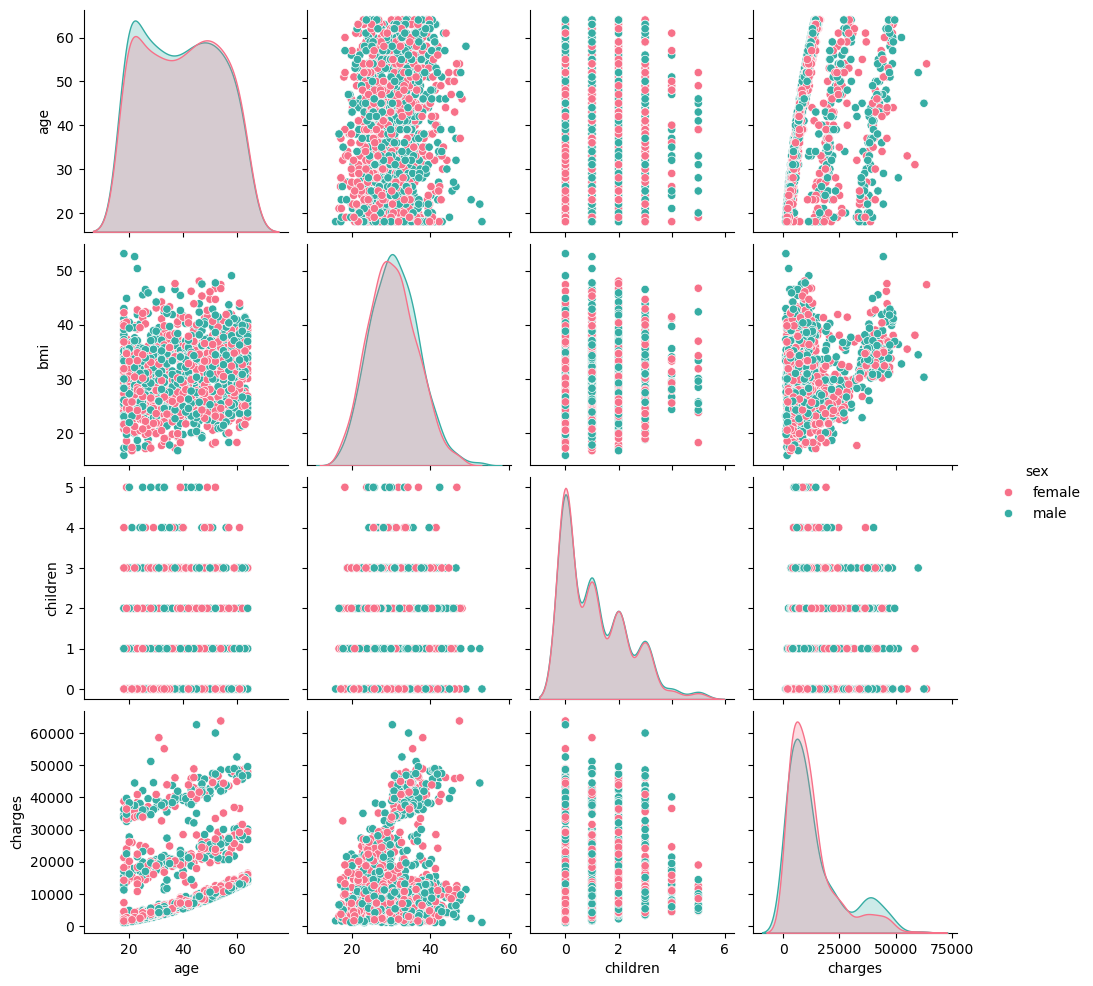

In [145]:
sb.pairplot(raw_data, diag_kind='kde', hue='sex', palette='husl')
plt.show()

### Feature Selection

In [8]:
def rfefeatures(indep_x,dep_y,n):
    rfelist = []

    lin_model = LinearRegression()
    svm_model = SVR(kernel = 'linear')
    dc_model = DecisionTreeRegressor(criterion = 'squared_error', max_features = 'sqrt', splitter = 'best', random_state=0)
    rf_model = RandomForestRegressor(n_estimators = 10,criterion = 'absolute_error', max_features = 'sqrt', random_state=0)

    rfemodellist = [lin_model,svm_model,dc_model,rf_model]

    for model in rfemodellist:
        rfe = RFE(estimator = model, n_features_to_select=n)
        rfe.fit(indep_x,dep_y)
        rfe_features = rfe.transform(indep_x)
        rfelist.append(rfe_features)
        selected_indices = rfe.get_support(indices=True)
        rfe_features_names = indep_x.columns[selected_indices]
    return rfelist,rfe_features_names.tolist()

In [9]:
def split_scaler(indep_x,dep_y):
    x_train,x_test,y_train,y_test = train_test_split(indep_x,dep_y,test_size=0.2,random_state=0)
    sc = StandardScaler()
    x_train = sc.fit_transform(x_train)
    x_test = sc.transform(x_test)
    return x_train,x_test,y_train,y_test,sc

In [10]:
def R2_prediction(regressor,x_test,y_test):
    y_pred = regressor.predict(x_test)
    R2_score = r2_score(y_test,y_pred)
    return regressor,R2_score

In [11]:
def linear(x_train,y_train,x_test):
    regressor = LinearRegression()
    regressor.fit(x_train,y_train)
    return R2_prediction(regressor,x_test,y_test)

In [12]:
def svm_linear(x_train,y_train,x_test):
    regressor = SVR(kernel = 'linear')
    regressor.fit(x_train,y_train)
    return R2_prediction(regressor,x_test,y_test)

In [13]:
def svm_nonlinear(x_train,y_train,x_test):
    regressor = SVR(kernel = 'rbf')
    regressor.fit(x_train,y_train)
    return R2_prediction(regressor,x_test,y_test)

In [14]:
def decision(x_train,y_train,x_test):
    regressor = DecisionTreeRegressor(criterion = 'squared_error', max_features = 'sqrt', splitter = 'best', random_state=0)
    regressor.fit(x_train,y_train)
    return R2_prediction(regressor,x_test,y_test)

In [15]:
def random(x_train,y_train,x_test):
    regressor = RandomForestRegressor(n_estimators = 10,criterion = 'absolute_error', max_features = 'sqrt', random_state=0)
    regressor.fit(x_train,y_train)
    return R2_prediction(regressor,x_test,y_test)

In [16]:
def rfe_regression(r2lin,r2svml,r2svmnl,r2dc,r2rf):
    rfe_dataframe = pd.DataFrame(index = ['Linear','SVM','Decision','Random'], columns = ['Linear','SVM_l','SVM_nl','Decision','Random'])
    for index in rfe_dataframe.index:
        rfe_dataframe['Linear'][index] = r2lin
        rfe_dataframe['SVM_l'][index] = r2svml
        rfe_dataframe['SVM_nl'][index] = r2svmnl
        rfe_dataframe['Decision'][index] = r2dc
        rfe_dataframe['Random'][index] = r2rf
    return rfe_dataframe

In [17]:
indep_x = data.drop('charges',axis=1)
dep_y  = data['charges']

In [18]:
dep_y

0       16884.92400
1        1725.55230
2        4449.46200
3       21984.47061
4        3866.85520
           ...     
1333    10600.54830
1334     2205.98080
1335     1629.83350
1336     2007.94500
1337    29141.36030
Name: charges, Length: 1338, dtype: float64

In [19]:
indep_x

,age,bmi,children,sex_male,smoker_yes
0,19,27.900,0,0,1
1,18,33.770,1,1,0
2,28,33.000,3,1,0
3,33,22.705,0,1,0
4,32,28.880,0,1,0
...,...,...,...,...,...
1333,50,30.970,3,1,0
1334,18,31.920,0,0,0
1335,18,36.850,0,0,0
1336,21,25.800,0,0,0


In [20]:
rfelist,rfe_features_names = rfefeatures(indep_x,dep_y,4)

r2lin = []
r2svml = []
r2svmnl = []
r2dc = []
r2rf = []

In [21]:
rfe_features_names

['age', 'bmi', 'children', 'smoker_yes']

### Model Selection

In [22]:
for i in rfelist:
    x_train,x_test,y_train,y_test,sc = split_scaler(i,dep_y)

    regressor,R2_score = linear(x_train,y_train,x_test)
    r2lin.append(R2_score)

    regressor,R2_score = svm_linear(x_train,y_train,x_test)
    r2svml.append(R2_score)

    regressor,R2_score = svm_nonlinear(x_train,y_train,x_test)
    r2svmnl.append(R2_score)

    regressor,R2_score = decision(x_train,y_train,x_test)
    r2dc.append(R2_score)

    regressor,R2_score = random(x_train,y_train,x_test)
    r2rf.append(R2_score)

result = rfe_regression(r2lin[0],r2svml[0],r2svmnl[0],r2dc[0],r2rf[0])
    

In [23]:
result
#4

,Linear,SVM_l,SVM_nl,Decision,Random
Linear,0.797827,-0.012085,-0.096625,0.629596,0.861888
SVM,0.797827,-0.012085,-0.096625,0.629596,0.861888
Decision,0.797827,-0.012085,-0.096625,0.629596,0.861888
Random,0.797827,-0.012085,-0.096625,0.629596,0.861888


### Gridsearch

In [24]:
params_grid = {'criterion' : ['squared_error', 'friedman_mse', 'absolute_error', 'poisson'],
               'n_estimators' : [50,100,500,1000,2000],
               'max_features' : ['sqrt', 'log2']}

In [25]:
grid = GridSearchCV(RandomForestRegressor(), params_grid, refit=True, verbose=3,n_jobs=-1)
grid_model = grid.fit(x_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


In [26]:
grid_predictions = grid_model.predict(x_test)

In [27]:
results = grid_model.cv_results_

R2_score = r2_score(y_test,grid_predictions)

In [28]:
print('Best parameters of RF_Grid :',format(grid_model.best_params_),R2_score)

Best parameters of RF_Grid : {'criterion': 'friedman_mse', 'max_features': 'sqrt', 'n_estimators': 2000} 0.8789162578475244


In [29]:
Grid_Table = pd.DataFrame(results)
Grid_Table

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_features,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.272300,0.014002,0.012545,0.002757,squared_error,sqrt,50,"{'criterion': 'squared_error', 'max_features':...",0.854429,0.814245,0.808337,0.838926,0.768275,0.816842,0.029456,38
1,0.586243,0.036919,0.019300,0.002606,squared_error,sqrt,100,"{'criterion': 'squared_error', 'max_features':...",0.857003,0.822002,0.811696,0.842019,0.774663,0.821476,0.028184,2
2,3.567932,0.115150,0.105194,0.012178,squared_error,sqrt,500,"{'criterion': 'squared_error', 'max_features':...",0.857075,0.820508,0.811046,0.841244,0.774110,0.820796,0.028316,18
3,5.981142,0.499496,0.192506,0.031872,squared_error,sqrt,1000,"{'criterion': 'squared_error', 'max_features':...",0.856759,0.821932,0.811488,0.842289,0.774411,0.821376,0.028260,3
4,10.387815,0.111768,0.369158,0.049496,squared_error,sqrt,2000,"{'criterion': 'squared_error', 'max_features':...",0.857089,0.820793,0.811478,0.841142,0.775022,0.821105,0.027974,6
5,0.238977,0.003656,0.010079,0.001111,squared_error,log2,50,"{'criterion': 'squared_error', 'max_features':...",0.858834,0.819833,0.808897,0.840594,0.771145,0.819861,0.029807,28
6,0.508434,0.016700,0.018460,0.000612,squared_error,log2,100,"{'criterion': 'squared_error', 'max_features':...",0.853972,0.821162,0.804805,0.840305,0.773300,0.818709,0.028182,31
7,2.548181,0.106900,0.087947,0.006127,squared_error,log2,500,"{'criterion': 'squared_error', 'max_features':...",0.856634,0.820341,0.810471,0.840763,0.775114,0.820664,0.027845,22
8,4.989180,0.125178,0.169519,0.004842,squared_error,log2,1000,"{'criterion': 'squared_error', 'max_features':...",0.857339,0.821103,0.809728,0.840485,0.775372,0.820805,0.027960,16
9,10.467726,0.107766,0.376788,0.016071,squared_error,log2,2000,"{'criterion': 'squared_error', 'max_features':...",0.857696,0.820430,0.811384,0.841296,0.774365,0.821034,0.028377,9


### Save the Model

In [30]:
filename = 'Finalized_InsuranceChargePrediction_Model.sav'
pickle.dump(regressor,open(filename,'wb'))

In [31]:
filenameSc = 'sc.pkl'
pickle.dump(sc,open(filenameSc,'wb'))

In [32]:
sc = pickle.load(open('sc.pkl','rb'))

In [33]:
user_input = sc.transform([[45,30,3,1]])
user_input

array([[ 0.41958265, -0.11773994,  1.58741222,  1.97125461]])

In [34]:
loaded_model = pickle.load(open('Finalized_InsuranceChargePrediction_Model.sav','rb'))
Prediction = loaded_model.predict(user_input)

In [35]:
Prediction

array([36608.340804])